# 0. Imports and Dataset Load

In [2]:
# %pip install dynamax
# %pip install git+https://github.com/probml/rebayes.git
# %pip install jax-dataloader
# %pip install jax-tqdm
# %pip install flax
# %pip install avalanche-lib
# %pip install bayesian-optimization

In [3]:
from functools import partial
from pathlib import Path
import pickle

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm import trange
import jax_dataloader.core as jdl
import optax
from flax.training.train_state import TrainState

from rebayes.low_rank_filter.lofi import LoFiParams
from rebayes.sgd_filter import sgd
from demos.showdown.classification import (
    permuted_mnist as core,
    classification_train as benchmark,
    hparam_tune_clf as hpt,
)

In [54]:
data_kwargs = {
    'n_tasks': 10,
    'ntrain_per_task': 300,
    'nval_per_task': 1_000,
    'ntest_per_task': 1_000,
}

dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, fashion=True)

output_path = Path(Path.cwd(), 'output', 'permuted-mnist', 'toy-experiment-2')
output_path.mkdir(parents=True, exist_ok=True)

In [55]:
features = [100, 100, 10]
model_dict = benchmark.init_model(type='mlp', features=features)

In [56]:
(Xtr, Ytr), (Xval, Yval), (Xte, Yte) = dataset.values()

In [57]:
train = (Xtr, Ytr)
val = (Xval, Yval)
test = (Xte, Yte)

In [58]:
ll_callback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda y_pred, y: -optax.softmax_cross_entropy(y_pred, y).mean(),
)

In [59]:
# ll_callback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)

# 1. FDEKF

## 1.1 Hyperparam Tuning

In [118]:
pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-34, -12),
    'log_dynamics_cov': (-34, -12),
    'log_alpha': (-34, -12),
}

In [119]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val,
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'fdekf', callback_at_end=False,
)

In [120]:
%%time
fdekf_optimizer.maximize(
    init_points=40,
    n_iter=45,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.099    | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.288    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.292    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.29     | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.073    | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.277    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.203    | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -2.088    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.239    | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.203    | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.274    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.165    | -18.19    | 

## 1.2 Test-Set Evaluation

In [ ]:
fdekf_hparams = {
    'initial_covariance': 0.03027819833308626,
    'dynamics_weights': 0.9999999999763863,
    'dynamics_covariance': 1.0457181213566393e-07,
    'dynamics_covariance_inflation_factor': 8.069199348080187e-07
}

In [135]:
# fdekf_hparams = hpt.get_best_params(fdekf_optimizer, method="fdekf")
fdekf_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                      fdekf_hparams, model_dict['emission_mean_function'],
                                      model_dict['emission_cov_function'], 
                                      method="fdekf")

In [136]:
fdekf_hparams

{'initial_covariance': 0.03027819833308626,
 'dynamics_weights': 0.9999999999763863,
 'dynamics_covariance': 1.0457181213566393e-07,
 'dynamics_covariance_inflation_factor': 8.069199348080187e-07}

In [123]:
accuracy_fn = lambda logits, label: jnp.mean(logits.argmax(axis=-1) == label)
evaluate_accuracy = partial(
    benchmark.evaluate_function,
    loss_fn=accuracy_fn
)

In [124]:
def test_acc_callback(bel, pred_obs, t, x, y, bel_pred, i, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    ntest_per_batch = kwargs["ntest_per_batch"]
    
    prev_test_batch, curr_test_batch = i*ntest_per_batch, (i+1)*ntest_per_batch
    curr_X_test, curr_y_test = X_test[prev_test_batch:curr_test_batch], y_test[prev_test_batch:curr_test_batch]
    cum_X_test, cum_y_test = X_test[:curr_test_batch], y_test[:curr_test_batch]
    
    overall_accuracy = evaluate_accuracy(bel.mean, apply_fn, cum_X_test, cum_y_test)
    current_accuracy = evaluate_accuracy(bel.mean, apply_fn, curr_X_test, curr_y_test)
    task1_accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'current': current_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [125]:
def evaluate_model(estimator, n_iter=10, bel=None):
    overall_accs, current_accs, task1_accs = [], [], []
    for i in trange(n_iter):
        # Load dataset with random permutation and random shuffle
        dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, key=i, fashion=True)
        (Xtr, Ytr), _, (Xte, Yte) = dataset.values()
        train_ds = jdl.ArrayDataset(Xtr, Ytr)
        train_loader = jdl.DataLoaderJax(
            train_ds, batch_size=data_kwargs["ntrain_per_task"], shuffle=False, drop_last=False
        )

        test_kwargs = {
            'X_test': Xte,
            'y_test': Yte,
            'ntest_per_batch': data_kwargs["ntest_per_task"],
            'apply_fn': model_dict["apply_fn"],
        }

        _, accs = estimator.scan_dataloader(
            train_loader, 
            callback=test_acc_callback, 
            bel=bel,
            callback_at_end=False,
            **test_kwargs
        )
        overall_accs.append(jnp.array([res['overall'] for res in accs]))
        current_accs.append(jnp.array([res['current'] for res in accs]))
        task1_accs.append(jnp.array([res['task1'] for res in accs]))
    
    overall_accs, current_accs, task1_accs = jnp.array(overall_accs), jnp.array(current_accs), jnp.array(task1_accs)
    overall_accs, current_accs, task1_accs = \
        overall_accs.reshape((n_iter, -1)), current_accs.reshape((n_iter, -1)), task1_accs.reshape((n_iter, -1))

    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'current': current_accs.mean(axis=0),
        'current-std': current_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0),
    }
    
    return result

In [126]:
fdekf_res = evaluate_model(fdekf_estimator)

100%|██████████| 10/10 [01:54<00:00, 11.41s/it]


In [127]:
filename = f'fdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(fdekf_res, f)

# 2. VDEKF

## 2.1 Hyperparam Tuning

In [128]:
vdekf_model = 'vdekf'

In [137]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val,
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'vdekf', callback_at_end=False,
)

In [138]:
%%time
vdekf_optimizer.maximize(
    init_points=40,
    n_iter=45,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.077    | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.288    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.292    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.29     | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.073    | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.277    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.167    | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -2.088    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.239    | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.203    | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.274    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.165    | -18.19    | 

## 2.2 Test-Set Evaluation

In [ ]:
# vdekf_hparams = {
#     'initial_covariance': 0.05633026000061478,
#     'dynamics_weights': 0.9999999978202987,
#     'dynamics_covariance': 1.0517918030707714e-09,
#     'dynamics_covariance_inflation_factor': 6.7546308918862706e-12
# }

In [139]:
vdekf_hparams = hpt.get_best_params(vdekf_optimizer, method=vdekf_model)
vdekf_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                      vdekf_hparams, model_dict['emission_mean_function'],
                                      model_dict['emission_cov_function'], 
                                      method="vdekf")

In [140]:
vdekf_hparams

{'initial_covariance': 0.029485467622780426,
 'dynamics_weights': 0.9999998427444926,
 'dynamics_covariance': 6.7513252987044414e-09,
 'dynamics_covariance_inflation_factor': 1.504090167922551e-08}

In [141]:
vdekf_res = evaluate_model(vdekf_estimator)

100%|██████████| 10/10 [02:16<00:00, 13.60s/it]


In [142]:
filename = f'vdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(vdekf_res, f)

# 3. LoFi (Rank 1)

## 3.1 Hyperparam Tuning

In [ ]:
lofi_1_params = LoFiParams(
    memory_size=1,
    diagonal_covariance=True,
)

In [ ]:
lofi_1_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'lofi', lofi_params=lofi_1_params, callback_at_end=False,
    inflation='hybrid',
)

In [ ]:
%%time
lofi_1_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.105    | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.294    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.295    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.294    | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.085    | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.287    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.163    | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -2.079    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.268    | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.24     | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.294    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.233    | -18.19    | 

## 3.2 Test-Set Evaluation

In [ ]:
lofi_1_hparams = {
    'initial_covariance': 0.033681523101810135,
    'dynamics_weights': 0.9999999999999115,
    'dynamics_covariance': 1.2414462847010143e-14,
    'dynamics_covariance_inflation_factor': 3.0710277851870785e-06
}

In [ ]:
# lofi_1_hparams = hpt.get_best_params(lofi_1_optimizer, method='lofi')
lofi_1_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       lofi_1_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='lofi', lofi_params=lofi_1_params)

In [ ]:
lofi_1_hparams

{'initial_covariance': 0.033681523101810135,
 'dynamics_weights': 0.9999999999999115,
 'dynamics_covariance': 1.2414462847010143e-14,
 'dynamics_covariance_inflation_factor': 3.0710277851870785e-06}

In [ ]:
lofi_1_res = evaluate_model(lofi_1_estimator)

100%|██████████| 10/10 [01:53<00:00, 11.30s/it]


In [ ]:
filename = f'lofi_1_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_1_res, f)

# 4. LoFi (Rank 2)

## 4.1 Hyperparam Tuning

In [ ]:
lofi_2_params = LoFiParams(
    memory_size=2,
    diagonal_covariance=True,
)

In [ ]:
lofi_2_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_2_params, callback_at_end=False,
    inflation='hybrid',
)

In [ ]:
%%time
lofi_2_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.08     | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.294    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.295    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.294    | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.081    | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.288    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.145    | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -2.076    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.268    | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.238    | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.294    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.231    | -18.19    | 

## 4.2 Test-Set Evaluation

In [ ]:
# lofi_2_hparams = {
#     'initial_covariance': 0.04498977665476941,
#     'dynamics_weights': 0.9999999341856172,
#     'dynamics_covariance': 3.7072569087393255e-06,
#     'dynamics_covariance_inflation_factor': 1.0360113255889495e-16
# }

In [ ]:
lofi_2_hparams = hpt.get_best_params(lofi_2_optimizer, method='lofi')
lofi_2_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       lofi_2_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='lofi', lofi_params=lofi_2_params)

In [ ]:
lofi_2_hparams

{'initial_covariance': 0.029487275641808683,
 'dynamics_weights': 0.9999999999220639,
 'dynamics_covariance': 9.513621130030935e-12,
 'dynamics_covariance_inflation_factor': 1.149100294862309e-14}

In [104]:
lofi_2_res = evaluate_model(lofi_2_estimator)

NameError: ignored

In [ ]:
filename = f'lofi_2_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_2_res, f)

# 5. LoFi (Rank 5)

## 5.1 Hyperparam Tuning

In [167]:
lofi_5_params = LoFiParams(
    memory_size=5,
    diagonal_covariance=True,
)

In [170]:
lofi_5_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'lofi', lofi_params=lofi_5_params, callback_at_end=False,
    inflation='hybrid'
)

In [171]:
%%time
lofi_5_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.17     | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.298    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.298    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.298    | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.194    | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.296    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.19     | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -2.155    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.293    | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.288    | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.299    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.292    | -18.19    | 

## 5.2 Test-Set Evaluation

In [ ]:
lofi_5_hparams = {
    'initial_covariance': 0.09822148362446868,
    'dynamics_weights': 0.9999999996658756,
    'dynamics_covariance': 2.5502276694763806e-13,
    'dynamics_covariance_inflation_factor': 9.87487111658244e-08
}

In [175]:
# lofi_5_hparams = hpt.get_best_params(lofi_5_optimizer, method='lofi')
lofi_5_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       lofi_5_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='lofi', lofi_params=lofi_5_params)

In [176]:
lofi_5_hparams

{'initial_covariance': 0.09822148362446868,
 'dynamics_weights': 0.9999999996658756,
 'dynamics_covariance': 2.5502276694763806e-13,
 'dynamics_covariance_inflation_factor': 9.87487111658244e-08}

In [177]:
lofi_5_res = evaluate_model(lofi_5_estimator)

100%|██████████| 10/10 [02:12<00:00, 13.21s/it]


In [178]:
filename = f'lofi_5_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_5_res, f)

# 6. LoFi (Rank 10)

## 6.1 Hyperparam Tuning

In [107]:
lofi_10_params = LoFiParams(
    memory_size=10,
    diagonal_covariance=True,
)

In [108]:
lofi_10_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val,
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'lofi', callback_at_end=False, lofi_params=lofi_10_params,
    inflation='hybrid'
)

In [109]:
%%time
lofi_10_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.084    | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.297    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.297    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.296    | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.083    | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.292    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.079    | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -2.056    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.283    | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.266    | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.298    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.268    | -18.19    | 

## 6.2 Test-Set Evaluation

In [ ]:
# lofi_10_hparams = {
#     'initial_covariance': 0.05995961326736914,
#     'dynamics_weights': 0.9999999986949092,
#     'dynamics_covariance': 4.806609700750667e-06,
#     'dynamics_covariance_inflation_factor': 2.5556937412674148e-14
# }

In [110]:
lofi_10_hparams = hpt.get_best_params(lofi_10_optimizer, method='lofi')
lofi_10_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_10_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_10_params)

In [111]:
lofi_10_hparams

{'initial_covariance': 0.04115627582511321,
 'dynamics_weights': 0.9999992855273678,
 'dynamics_covariance': 7.736211973961815e-07,
 'dynamics_covariance_inflation_factor': 3.585063293296912e-08}

In [112]:
lofi_10_res = evaluate_model(lofi_10_estimator)

100%|██████████| 10/10 [02:19<00:00, 14.00s/it]


In [113]:
filename = f'lofi_10_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_10_res, f)

# 7. LoFi (Rank 20)

## 7.1 Hyperparam Tuning

In [82]:
lofi_20_params = LoFiParams(
    memory_size=20,
    diagonal_covariance=True,
)

In [83]:
lofi_20_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val,
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'lofi', lofi_params=lofi_20_params, callback_at_end=False,
    inflation='hybrid'
)

In [84]:
%%time
lofi_20_optimizer.maximize(
    init_points=40,
    n_iter=45,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.0      | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.288    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.292    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.29     | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.004    | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.275    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.039    | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -2.002    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.234    | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.194    | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.273    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.129    | -18.19    | 

## 7.2 Test-Set Evaluation

In [ ]:
# lofi_20_hparams = {
#     'initial_covariance': 0.02063530395807719,
#     'dynamics_weights': 0.9999999996609368,
#     'dynamics_covariance': 1.5747372913536692e-08,
#     'dynamics_covariance_inflation_factor': 2.922619811783013e-13
# }

In [85]:
lofi_20_hparams = hpt.get_best_params(lofi_20_optimizer, method='lofi')
lofi_20_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_20_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_20_params)

In [86]:
lofi_20_hparams

{'initial_covariance': 0.053468429056071375,
 'dynamics_weights': 0.999999999999962,
 'dynamics_covariance': 6.14421235332821e-06,
 'dynamics_covariance_inflation_factor': 2.3835619396399574e-08}

In [105]:
lofi_20_res = evaluate_model(lofi_20_estimator)

100%|██████████| 10/10 [06:02<00:00, 36.23s/it]


In [106]:
filename = f'lofi_20_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_20_res, f)

# 8. LoFi (Rank 50)

## 8.1 Hyperparam Tuning

In [ ]:
lofi_50_params = LoFiParams(
    memory_size=50,
    diagonal_covariance=True,
)

In [ ]:
lofi_50_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_50_params, callback_at_end=False,
    inflation='hybrid',
)

In [ ]:
%%time
lofi_50_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.995    | -13.83    | -21.05    | -28.17    | -2.168    |
| 2         | -2.294    | -13.8     | -15.8     | -17.99    | -7.395    |
| 3         | -2.295    | -13.94    | -28.26    | -17.14    | -7.385    |
| 4         | -2.294    | -31.31    | -25.51    | -15.52    | -7.218    |
| 5         | -2.04     | -32.46    | -20.07    | -21.14    | -4.188    |
| 6         | -2.288    | -19.1     | -18.88    | -24.34    | -6.791    |
| 7         | -2.019    | -21.45    | -23.44    | -15.06    | -1.652    |
| 8         | -1.987    | -31.67    | -32.67    | -20.87    | -2.076    |
| 9         | -2.27     | -29.02    | -22.23    | -31.01    | -6.278    |
| 10        | -2.242    | -30.66    | -24.54    | -16.56    | -5.93     |
| 11        | -2.295    | -30.09    | -14.0     | -22.0     | -8.995    |
| 12        | -2.232    | -18.19    | 

## 8.2 Test-Set Evaluation

In [ ]:
# lofi_50_hparams = {
#     'initial_covariance': 0.0528461431815614,
#     'dynamics_weights': 0.9999999999999192,
#     'dynamics_covariance': 1.2508122817643388e-07,
#     'dynamics_covariance_inflation_factor': 0.03488624312426102
# }

In [ ]:
lofi_50_hparams = hpt.get_best_params(lofi_50_optimizer, method='lofi')
lofi_50_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_50_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_50_params)

In [ ]:
lofi_50_hparams

{'initial_covariance': 0.05015546062317239,
 'dynamics_weights': 0.9999999994454266,
 'dynamics_covariance': 6.0976284910401465e-12,
 'dynamics_covariance_inflation_factor': 3.8135974162038054e-08}

In [ ]:
lofi_50_res = evaluate_model(lofi_50_estimator)

100%|██████████| 10/10 [08:02<00:00, 48.25s/it]


In [ ]:
filename = f'lofi_50_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_50_res, f)

# 9. Online Gradient Descent

## 9.1 Hyperparam Tuning

In [60]:
rsgd_pbounds = {
    'learning_rate': (1e-8, 1e-1),
}

In [61]:
ogd_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 1,
    'dim_output': 10
}

In [62]:
ogd_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'sgd', callback_at_end=False, **ogd_params
)

In [63]:
%%time
ogd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | learni... |
-------------------------------------
| 1         | -2.256    | 0.09169   |
| 2         | -1.84     | 0.05885   |
| 3         | -1.52     | 0.0265    |
| 4         | -1.996    | 0.07832   |
| 5         | -2.173    | 0.0918    |
| 6         | -2.124    | 0.08274   |
| 7         | -1.984    | 0.0728    |
| 8         | -1.504    | 0.02605   |
| 9         | -2.171    | 0.09118   |
| 10        | -1.506    | 0.02608   |
| 11        | -2.074    | 0.07664   |
| 12        | -1.5      | 0.02615   |
| 13        | -1.401    | 0.01223   |
| 14        | -1.654    | 0.0386    |
| 15        | -2.136    | 0.08401   |
| 16        | -1.523    | 0.02782   |
| 17        | -1.427    | 0.006991  |
| 18        | -1.92     | 0.06331   |
| 19        | -1.893    | 0.05848   |
| 20        | -1.927    | 0.05812   |
| 21        | -1.407    | 0.01145   |
| 22        | -1.416    | 0.007873  |
| 23        | -1.494    | 0.02483   |
| 24        | -1.401    | 0.009043  |
| 25        

## 9.2 Test-Set Evaluation

In [441]:
ogd_hparams = {
    'learning_rate': 0.01017584186141839
}

In [64]:
# ogd_hparams = hpt.get_best_params(ogd_optimizer, method='sgd')
ogd_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                    ogd_hparams, model_dict['emission_mean_function'],
                                    model_dict['emission_cov_function'], 
                                    method='sgd', **ogd_params)

In [65]:
ogd_hparams

{'learning_rate': 0.01017584186141839}

In [107]:
ogd_res = evaluate_model(ogd_estimator)

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


In [108]:
filename = f'ogd_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(ogd_res, f)

# 10. SGD-RB (Rank 20)

## 10.1 Hyperparam Tuning

In [68]:
rsgd_pbounds = {
    'learning_rate': (1e-8, 1e-1),
}

In [69]:
sgd_20_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 20,
    'dim_output': 10
}

In [70]:
sgd_20_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, train, val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_callback, 'sgd', callback_at_end=False, **sgd_20_params
)

In [71]:
%%time
sgd_20_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | learni... |
-------------------------------------
| 1         | -3.369e+1 | 0.09169   |
| 2         | -3.981    | 0.05885   |
| 3         | -2.431    | 0.0265    |
| 4         | -2.529    | 0.07832   |
| 5         | -2.621    | 0.0918    |
| 6         | -2.496    | 0.08274   |
| 7         | -2.486    | 0.0728    |
| 8         | -2.356    | 0.02605   |
| 9         | -3.326e+1 | 0.09118   |
| 10        | -2.301    | 0.02608   |
| 11        | -2.57     | 0.07664   |
| 12        | -4.74e+05 | 0.02615   |
| 13        | -1.848    | 0.01223   |
| 14        | -2.428    | 0.0386    |
| 15        | -70.65    | 0.08401   |
| 16        | -2.394    | 0.02782   |
| 17        | -1.339    | 0.006991  |
| 18        | -3.18     | 0.06331   |
| 19        | -6.256e+2 | 0.05848   |
| 20        | -2.553    | 0.05812   |
| 21        | -3.18     | 0.05783   |
| 22        | -7.895    | 0.05916   |
| 23        | -4.433e+1 | 0.08317   |
| 24        | -2.398e+0 | 0.0836    |
| 25        

## 10.2 Test-Set Evaluation

In [345]:
sgd_20_hparams = {
    'learning_rate': 0.006581081426541059
}

In [76]:
# sgd_20_hparams = hpt.get_best_params(sgd_20_optimizer, method='sgd')
sgd_20_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       sgd_20_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='sgd', **sgd_20_params)

In [77]:
sgd_20_hparams

{'learning_rate': 0.006581081426541059}

In [109]:
sgd_20_res = evaluate_model(sgd_20_estimator)

100%|██████████| 10/10 [01:31<00:00,  9.14s/it]


In [110]:
filename = f'sgd_20_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(sgd_20_res, f)

# 11. Offline SGD (baseline)

In [93]:
num_epochs, batch_size, key = 10_000, 32, jr.PRNGKey(0)

sgd_state = TrainState.create(
    apply_fn=model_dict['apply_fn'],
    params=model_dict['flat_params'],
    tx=optax.sgd(learning_rate=1e-4)
)

@partial(jit, static_argnums=(3,))
def sgd_loss_fn(params, X_batch, y_batch, apply_fn):
    logits = vmap(apply_fn, (None, 0))(params, X_batch).ravel()
    nll = jnp.mean(optax.softmax_cross_entropy(logits, y_batch.ravel()))

    return nll

In [94]:
sgd_state, losses = sgd.train_full(
    key, num_epochs, batch_size, sgd_state, Xtr, Ytr, sgd_loss_fn, Xte, jax.nn.one_hot(Yte, 10)
)

In [95]:
offline_sgd_acc = evaluate_accuracy(sgd_state.params, model_dict['apply_fn'], *test)

In [96]:
offline_sgd_miscl = 1 - offline_sgd_acc

In [97]:
filename = f'offline_sgd_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(offline_sgd_miscl, f)

# 12. Model Comparison

In [143]:
# Load Results
from pathlib import Path

output_path = Path(Path.cwd(), 'output', 'permuted-mnist', 'toy-experiment-2')
model_types = [
    'ogd',
    'sgd_20',
    'fdekf',
    'vdekf',
    # 'lofi_1',
    # 'lofi_5', 
    # 'lofi_10',
    'lofi_20',
    # 'lofi_50',
]
results = {}
for model_type in model_types:
    filename = f'{model_type}_result.pkl'
    with open(Path(output_path, filename), "rb") as f:
        results[model_type] = pickle.load(f)

In [144]:
boundaries = [i for i in range(300, (300*10)+1, 300)]
n_iter = 10

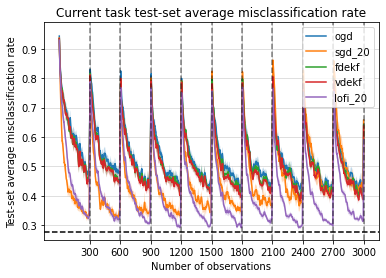

In [145]:
kernel = jnp.ones((10,)) / 10
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

fig, ax = plt.subplots()
for key, value in results.items():
    ax.plot(1.0 - convolve(value['current']), label=key)
    ax.fill_between(
        jnp.arange(value['current'].shape[0]),
        1.0 - convolve(value['current']) - (value['current-std'] / jnp.sqrt(n_iter)),
        1.0 - convolve(value['current']) + (value['current-std'] / jnp.sqrt(n_iter)),
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
# Offline SGD baseline
ax.axhline(y=offline_sgd_miscl, color = 'k', linestyle = '--');
ax.set_xticks(boundaries)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend(loc=1);

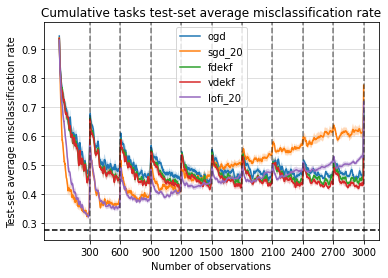

In [146]:
fig, ax = plt.subplots()
for key, value in results.items():
    ax.plot(1.0 - convolve(value['overall']), label=key)
    ax.fill_between(
        jnp.arange(value['overall'].shape[0]),
        1.0 - convolve(value['overall']) - (value['overall-std'])/jnp.sqrt(n_iter),
        1.0 - convolve(value['overall']) + (value['overall-std'])/jnp.sqrt(n_iter),
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
# Offline SGD baseline
ax.axhline(y=offline_sgd_miscl, color = 'k', linestyle = '--');
ax.set_xticks(boundaries)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

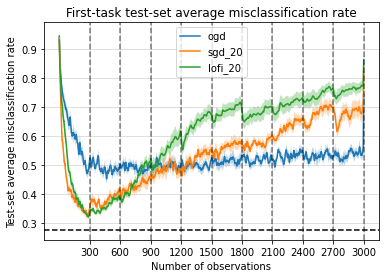

In [117]:
fig, ax = plt.subplots()
for key, value in results.items():
    ax.plot(1.0 - convolve(value['task1']), label=key)
    ax.fill_between(
        jnp.arange(value['task1'].shape[0]),
        1.0 - convolve(value['task1']) - (value['task1-std'])/jnp.sqrt(n_iter),
        1.0 - convolve(value['task1']) + (value['task1-std'])/jnp.sqrt(n_iter),
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
# Offline SGD baseline
ax.axhline(y=offline_sgd_miscl, color = 'k', linestyle = '--');
ax.set_xticks(boundaries)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'First-task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

# Load Results

In [ ]:
# Load Results
from pathlib import Path

output_path2 = Path(Path.cwd(), 'output', 'permuted-mnist', 'experiment-2')
model_types = [
    'fdekf', 
    'vdekf', 
    'lofi_1', 
    'lofi_5', 
    'lofi_10',
    'lofi_20', 
    'ogd', 
    # 'sgd_10',
    # 'sgd_20'
]
results_100 = {}
for model_type in model_types:
    filename = f'{model_type}_result.pkl'
    with open(Path(output_path2, filename), "rb") as f:
        results_100[model_type] = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
n_iter = 5

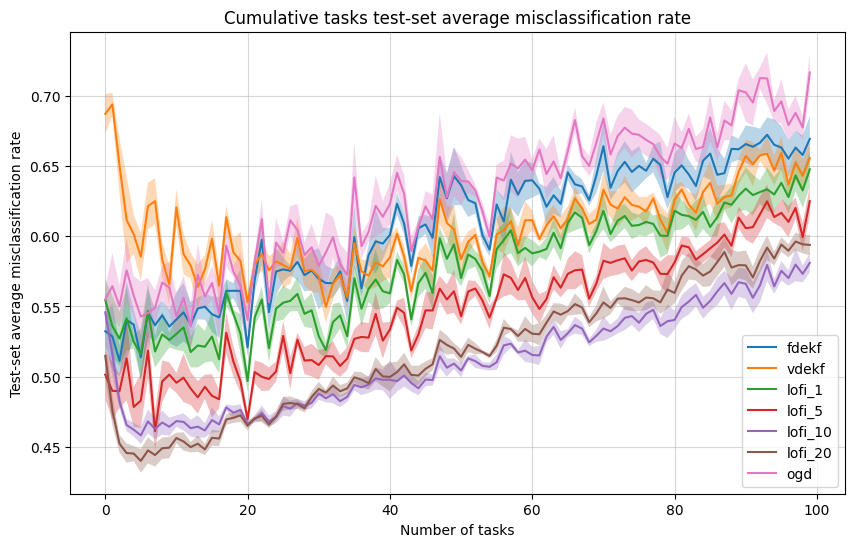

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, val in results_100.items():
    ax.plot(1.0 - val['overall'], label=key)
    ax.fill_between(
        jnp.arange(val['overall'].shape[0]),
        1.0 - val['overall'] - val['overall-std'] / jnp.sqrt(n_iter),
        1.0 - val['overall'] + val['overall-std'] / jnp.sqrt(n_iter),
        alpha=0.3
    )
# Task boundaries
ax.set_xlabel('Number of tasks')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

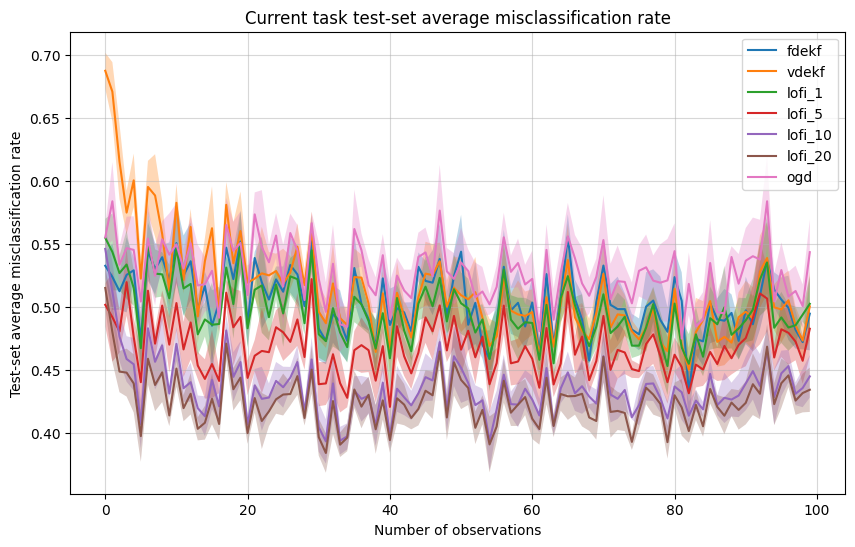

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, val in results_100.items():
    ax.plot(1.0 - val['current'], label=key)
    ax.fill_between(
        jnp.arange(val['current'].shape[0]),
        1.0 - val['current'] - val['current-std'] / jnp.sqrt(n_iter),
        1.0 - val['current'] + val['current-std'] / jnp.sqrt(n_iter),
        alpha=0.3
    )
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

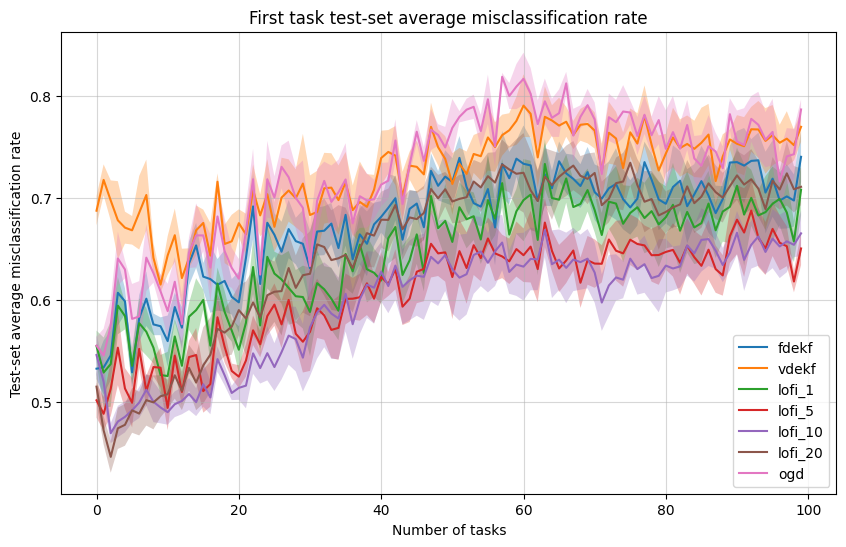

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, val in results_100.items():
    ax.plot(1.0 - val['task1'], label=key)
    ax.fill_between(
        jnp.arange(val['task1'].shape[0]),
        1.0 - val['task1'] - val['task1-std'] / jnp.sqrt(n_iter),
        1.0 - val['task1'] + val['task1-std'] / jnp.sqrt(n_iter),
        alpha=0.3
    )
ax.set_xlabel('Number of tasks')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'First task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();